In [42]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout, Dense, LSTM
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

In [43]:
import os

PATH = os.path.join("datasets", "price")

In [44]:
def load_data(filename, path= PATH):
    csv_path = os.path.join(path, filename)
    return pd.read_csv(csv_path)

In [45]:
dataset = load_data("XAU_USD-Historical-Data.csv")

In [46]:
dataset.head()

,Date,Price,Open,High,Low,% Change,% Change Tomorrow
0,1/1/2010,"1,097.35","1,097.25","1,097.90","1,097.05",0.10%,2.10%
1,1/4/2010,"1,120.40","1,096.25","1,123.80","1,093.45",2.10%,-0.12%
2,1/5/2010,"1,119.05","1,121.30","1,128.10","1,115.25",-0.12%,1.77%
3,1/6/2010,"1,138.90","1,118.40","1,140.60","1,116.00",1.77%,-0.58%
4,1/7/2010,"1,132.30","1,138.20","1,139.15","1,128.60",-0.58%,0.38%


In [47]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3645 entries, 0 to 3644
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Date               3645 non-null   object
 1   Price              3645 non-null   object
 2   Open               3645 non-null   object
 3   High               3645 non-null   object
 4   Low                3645 non-null   object
 5   % Change           3645 non-null   object
 6   % Change Tomorrow  3645 non-null   object
dtypes: object(7)
memory usage: 199.5+ KB


In [48]:
dataset.describe()

,Date,Price,Open,High,Low,% Change,% Change Tomorrow
count,3645,3645,3645,3645,3645,3645,3645
unique,3645,3471,3507,3510,3513,508,508
top,1/1/2010,"1,325.00","1,268.80","1,436.55","1,191.30",-0.33%,-0.33%
freq,1,3,4,3,4,28,28


In [49]:
column_list = ['Price', 'Open', 'High', 'Low']
for column in column_list:
    dataset[column] = dataset[column].replace({',': ''}, regex=True)
dataset[column_list] = dataset[column_list].astype(float)

column_list = ['% Change', '% Change Tomorrow']
for column in column_list:
    dataset[column] = dataset[column].replace({'%': ''}, regex=True)
dataset[column_list] = dataset[column_list].astype(float)

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3645 entries, 0 to 3644
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               3645 non-null   object 
 1   Price              3645 non-null   float64
 2   Open               3645 non-null   float64
 3   High               3645 non-null   float64
 4   Low                3645 non-null   float64
 5   % Change           3645 non-null   float64
 6   % Change Tomorrow  3645 non-null   float64
dtypes: float64(6), object(1)
memory usage: 199.5+ KB


In [50]:
dataset.isna().sum().sort_values(ascending=False)

Date                 0
Price                0
Open                 0
High                 0
Low                  0
% Change             0
% Change Tomorrow    0
dtype: int64

In [51]:
def assign_label(percent_change):
    labels = []
    for change in percent_change:
        if change > 3:
            labels.append('Tăng trên 3%')
        elif change > 2.5 and change < 3:
            labels.append('Tăng trên 2.5%')
        elif change > 2.5 and change < 3:
            labels.append('Tăng trên 2%')
        elif change > 1.5 and change < 2:
            labels.append('Tăng trên 1.5%')
        elif change > 1 and change < 1.5:
            labels.append('Tăng trên 1%')
        elif change > 0.5 and change < 1:
            labels.append('Tăng trên 0.5%')
        elif change > 0 and change < 0.5:
            labels.append('Tăng trên 0%')
        elif change < 0 and change > -0.5:
            labels.append('Giảm trên 0%')
        elif change < -0.5 and change > -1:
            labels.append('Giảm trên 0.5%')
        elif change < -1 and change > -1.5:
            labels.append('Giảm trên 1%')
        elif change < -1.5 and change > -2:
            labels.append('Giảm trên 1.5%')
        elif change < -2 and change > -2.5:
            labels.append('Giảm trên 2%')
        elif change < -2.5 and change > -3:
            labels.append('Giảm trên 2.5%')
        elif change < -3:
            labels.append('Giảm trên 3%')
        else:
            labels.append('Không đổi')
    return labels

# Sử dụng hàm để gán nhãn cho mỗi mẫu dữ liệu
percent_change = dataset['% Change Tomorrow']
labels = assign_label(percent_change)
pre_labels = pd.DataFrame({'Label': labels})

In [52]:
def compute_daily_returns(df):
    "Compute and return the daily return values."""
    # TODO: Your code here
    # Note: Returned DataFrame must have the same number of rows
    daily_return = (df / df.shift(1)) - 1
    daily_return[0] = 0
    return daily_return

In [53]:
dataset.head()

,Date,Price,Open,High,Low,% Change,% Change Tomorrow
0,1/1/2010,1097.35,1097.25,1097.90,1097.05,0.10,2.10
1,1/4/2010,1120.40,1096.25,1123.80,1093.45,2.10,-0.12
2,1/5/2010,1119.05,1121.30,1128.10,1115.25,-0.12,1.77
3,1/6/2010,1138.90,1118.40,1140.60,1116.00,1.77,-0.58
4,1/7/2010,1132.30,1138.20,1139.15,1128.60,-0.58,0.38


In [54]:
date = dataset['Date']
close_price = dataset['Price']
open_price = dataset['Open']
high_price = dataset['High']
low_price = dataset['Low']
change = dataset['% Change']
change_tomorrow = dataset['% Change Tomorrow']

In [55]:
close_price_return = compute_daily_returns(close_price)
open_price_return = compute_daily_returns(open_price)
high_price_return = compute_daily_returns(high_price)
low_price_return = compute_daily_returns(low_price)
change_return = compute_daily_returns(change)
change_tomorrow_return = compute_daily_returns(change_tomorrow)

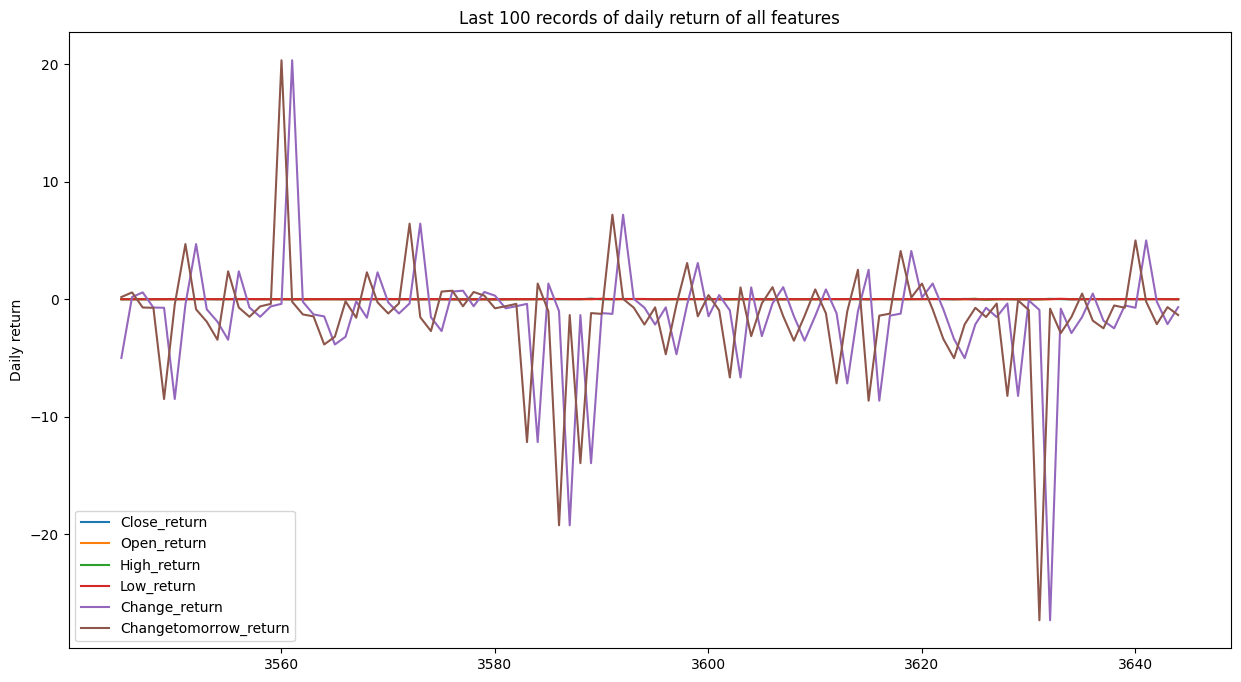

In [56]:
df_d = pd.DataFrame({'Close_return':close_price_return, 'Open_return':open_price_return, 'High_return':high_price_return, 'Low_return':low_price_return, 'Change_return':change_return,
                  'Changetomorrow_return':change_tomorrow_return})

daily_ax = df_d[-100:].plot(title='Last 100 records of daily return of all features',figsize=(15,8))

daily_ax.set_ylabel('Daily return')
daily_ax.legend(loc='lower left')
plt.show()

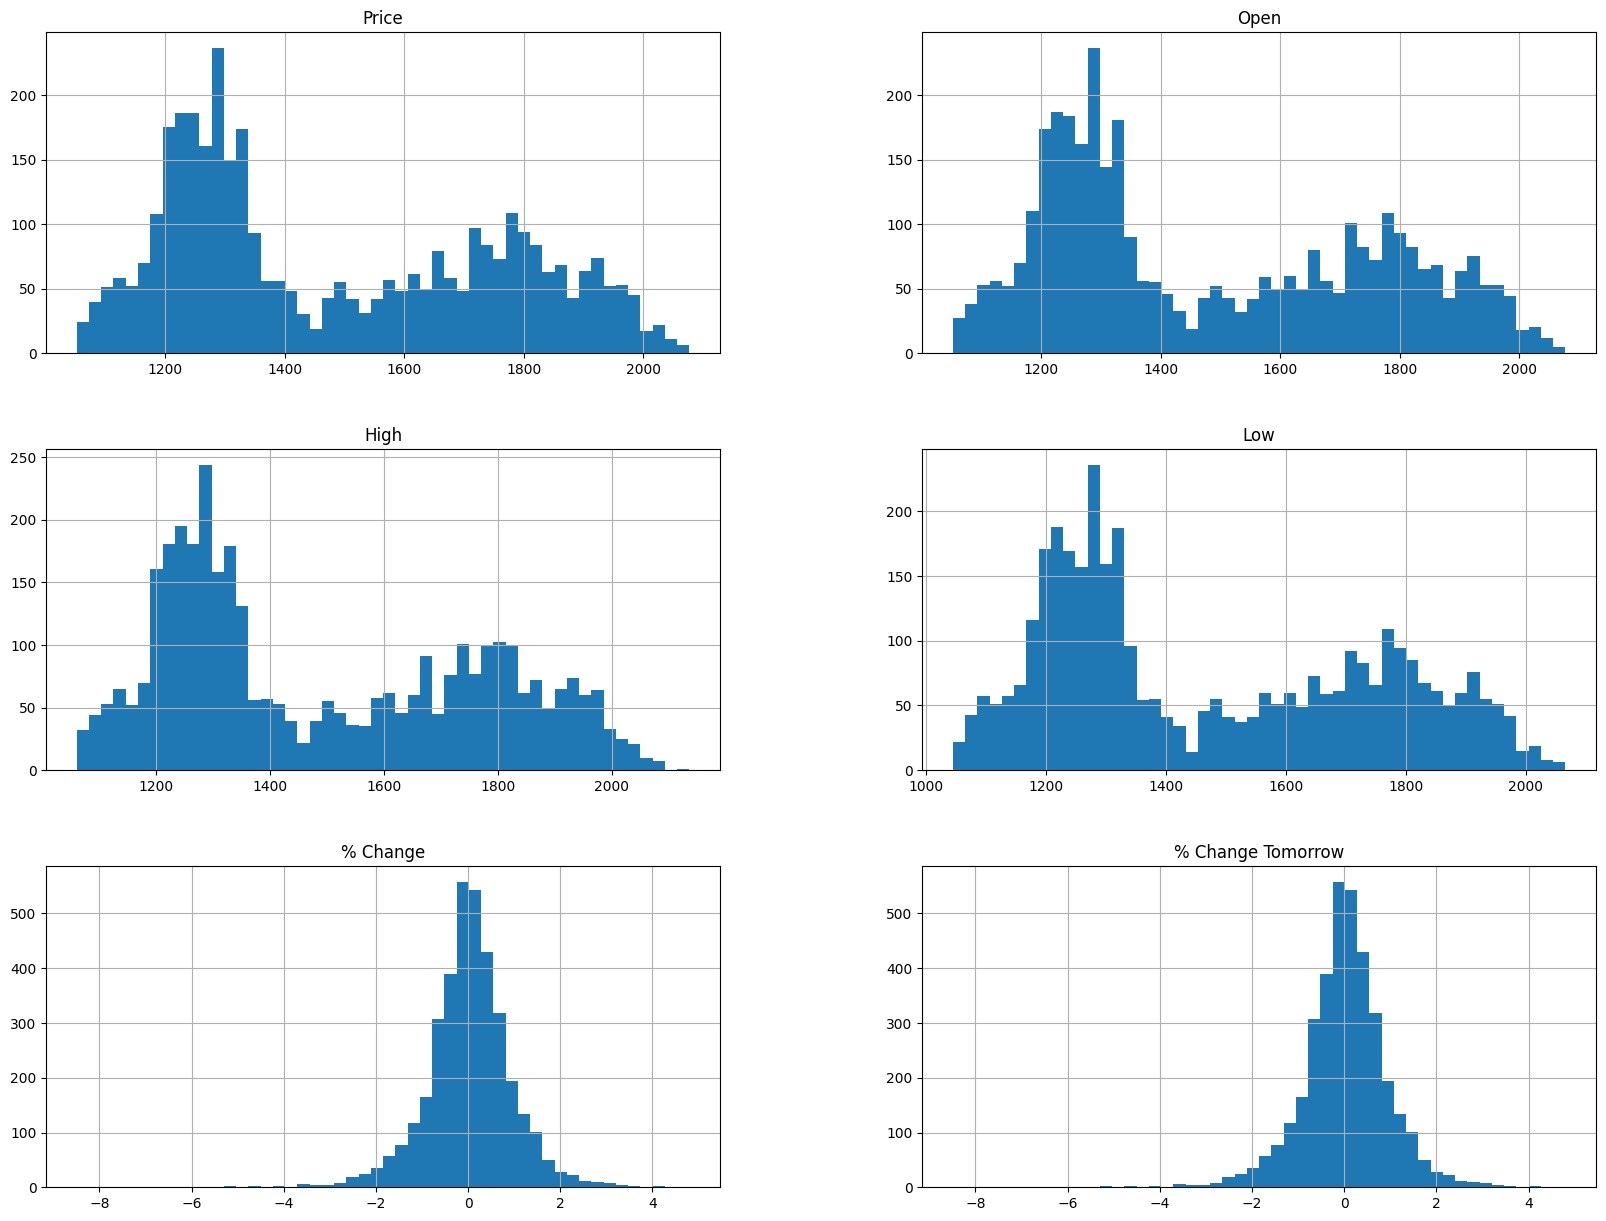

In [57]:
import matplotlib.pyplot as plt

dataset.hist(bins=50, figsize=(20,15))
plt.show()

<Axes: xlabel='Price', ylabel='Open'>

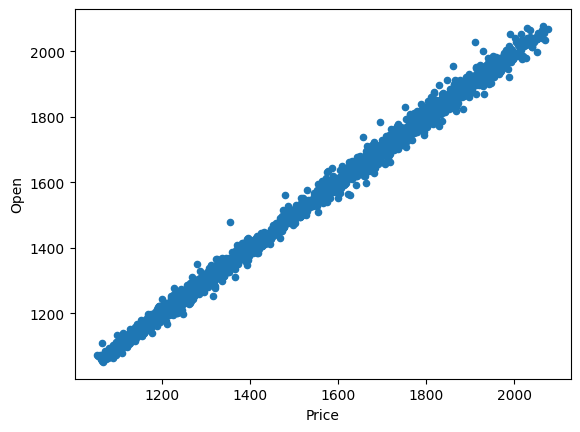

In [58]:
dataset.plot(kind='scatter', x='Price', y='Open')

<Axes: xlabel='Open', ylabel='High'>

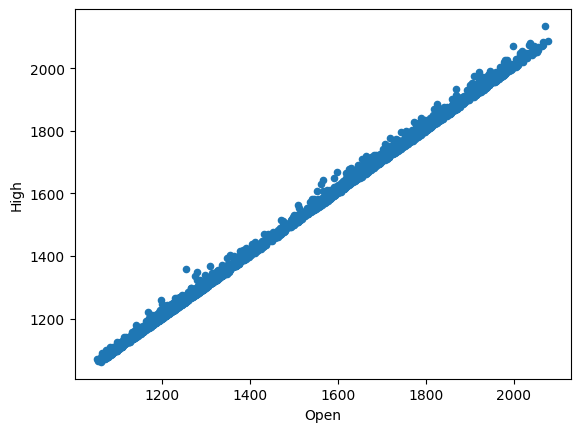

In [59]:
dataset.plot(kind='scatter', x='Open', y='High')

<Axes: xlabel='High', ylabel='Low'>

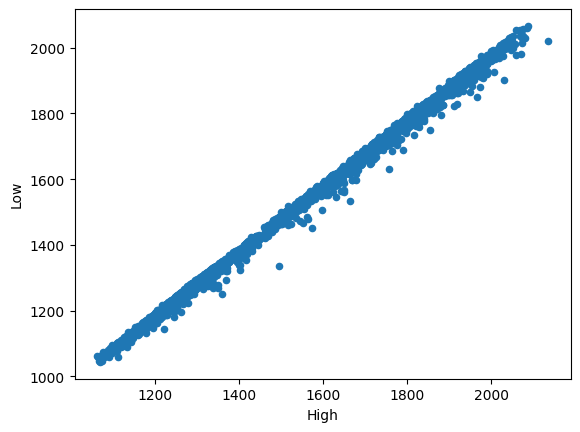

In [60]:
dataset.plot(kind='scatter', x='High', y='Low')

In [61]:
data = dataset.copy()
data_expDate = data.drop("Date", axis=1)

In [62]:
corr_matrix = data_expDate.corr()

In [63]:
corr_matrix["% Change Tomorrow"].sort_values(ascending=False)

% Change Tomorrow    1.000000
% Change             0.001363
Price               -0.023019
Low                 -0.023127
Open                -0.023218
High                -0.023882
Name: % Change Tomorrow, dtype: float64

In [64]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: C:\Users\T480s\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip


<Axes: >

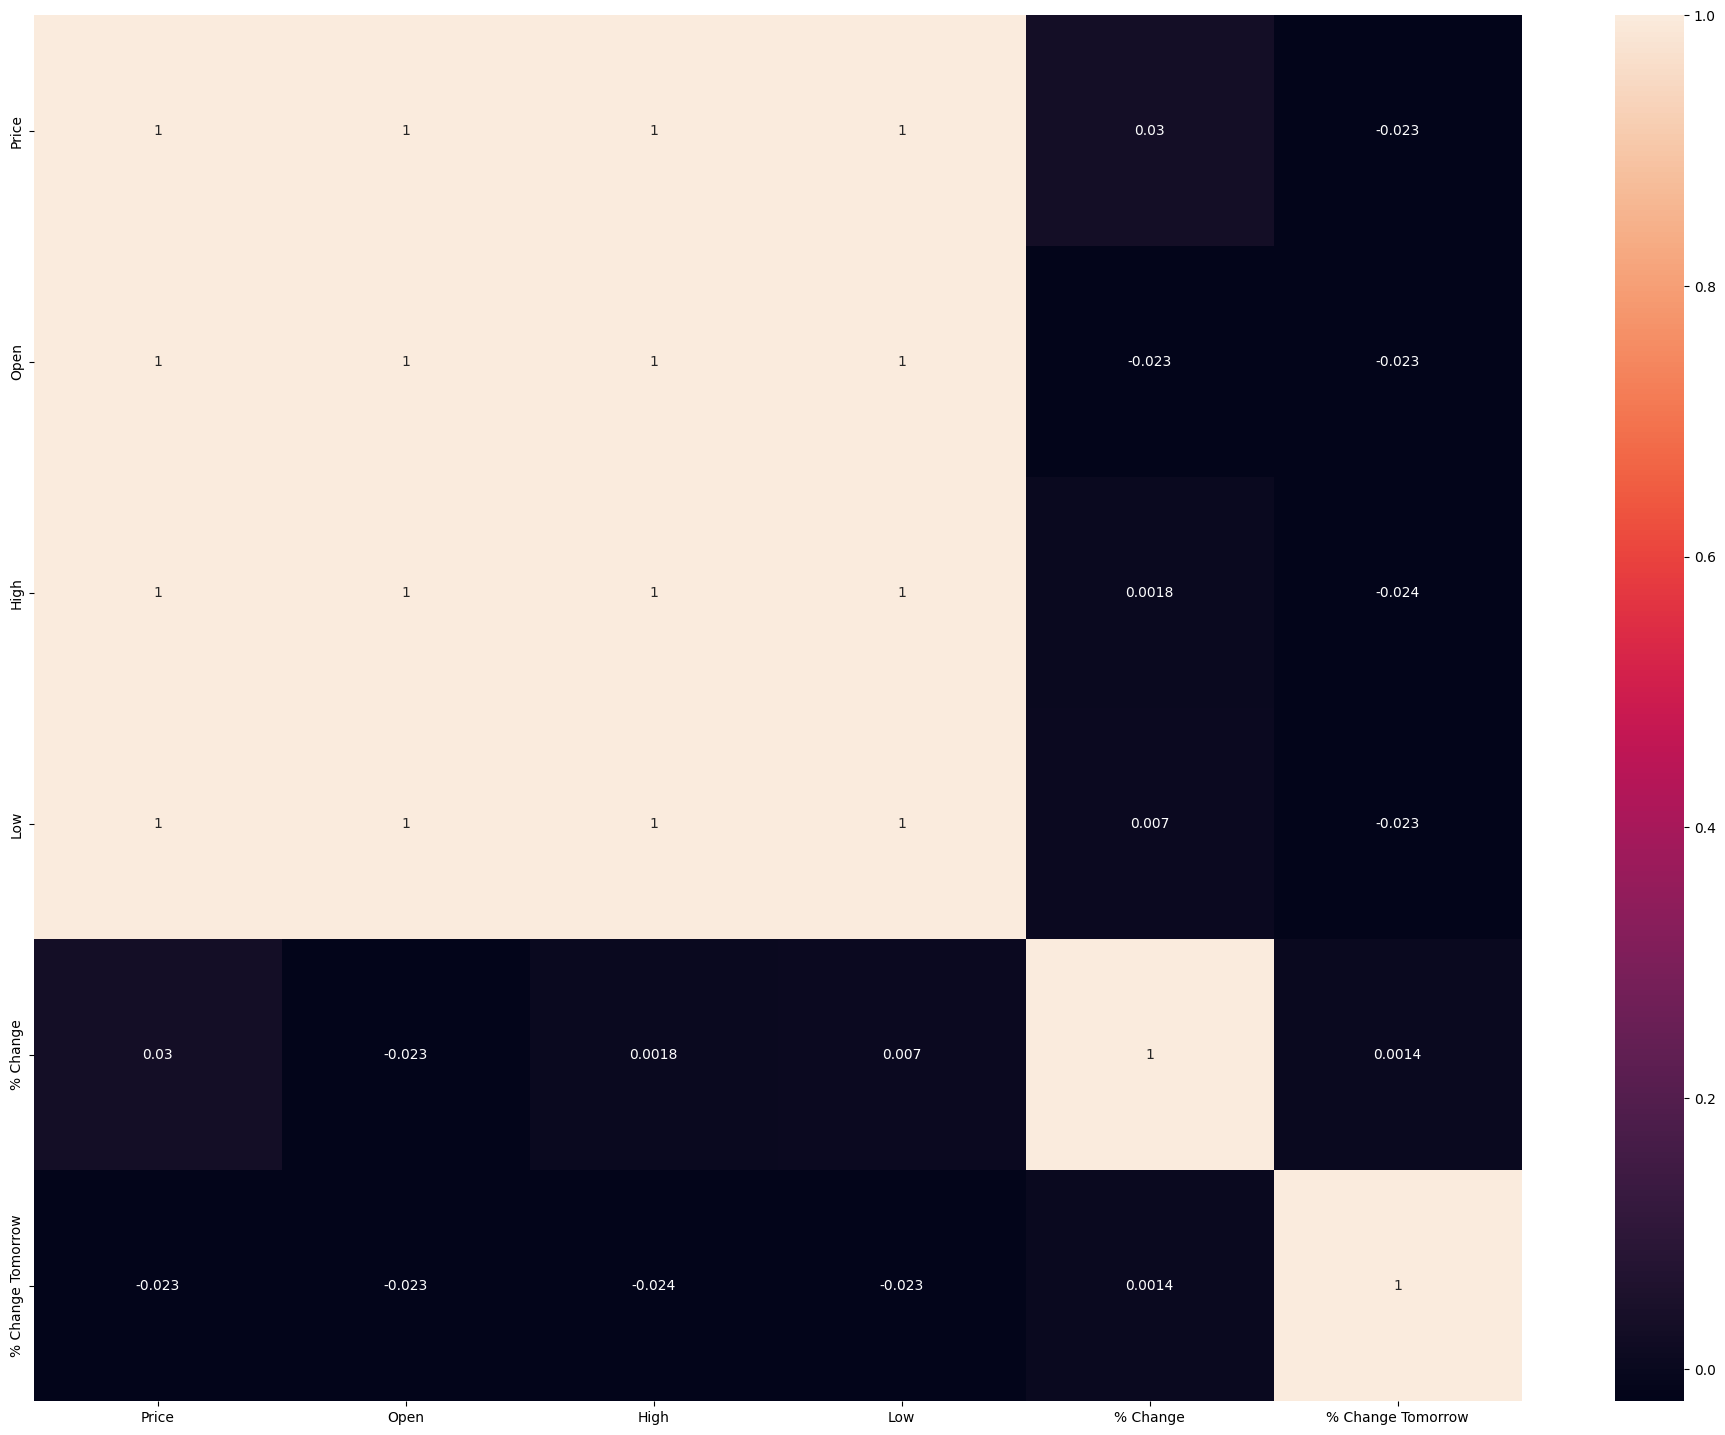

In [65]:
import seaborn as sns

plt.figure(figsize=(24,18)) 
sns.heatmap(data_expDate.corr(), annot=True) 

In [66]:
def calculate_MACD(df, nslow=26, nfast=12):
    emaslow = df.ewm(span=nslow, min_periods=nslow, adjust=True, ignore_na=False).mean()
    emafast = df.ewm(span=nfast, min_periods=nfast, adjust=True, ignore_na=False).mean()
    dif = emafast - emaslow
    MACD = dif.ewm(span=9, min_periods=9, adjust=True, ignore_na=False).mean()
    return dif, MACD

def calculate_RSI(df, periods=14):
    # wilder's RSI
    delta = df.diff()
    up, down = delta.copy(), delta.copy()

    up[up < 0] = 0
    down[down > 0] = 0

    rUp = up.ewm(com=periods,adjust=False).mean()
    rDown = down.ewm(com=periods, adjust=False).mean().abs()

    rsi = 100 - 100 / (1 + rUp / rDown)
    return rsi

def calculate_SMA(df, peroids=15):
    SMA = df.rolling(window=peroids, min_periods=peroids, center=False).mean()
    return SMA

def calculate_BB(df, peroids=15):
    STD = df.rolling(window=peroids,min_periods=peroids, center=False).std()
    SMA = calculate_SMA(df)
    upper_band = SMA + (2 * STD)
    lower_band = SMA - (2 * STD)
    return upper_band, lower_band

def calculate_stdev(df,periods=5):
    STDEV = df.rolling(periods).std()
    return STDEV

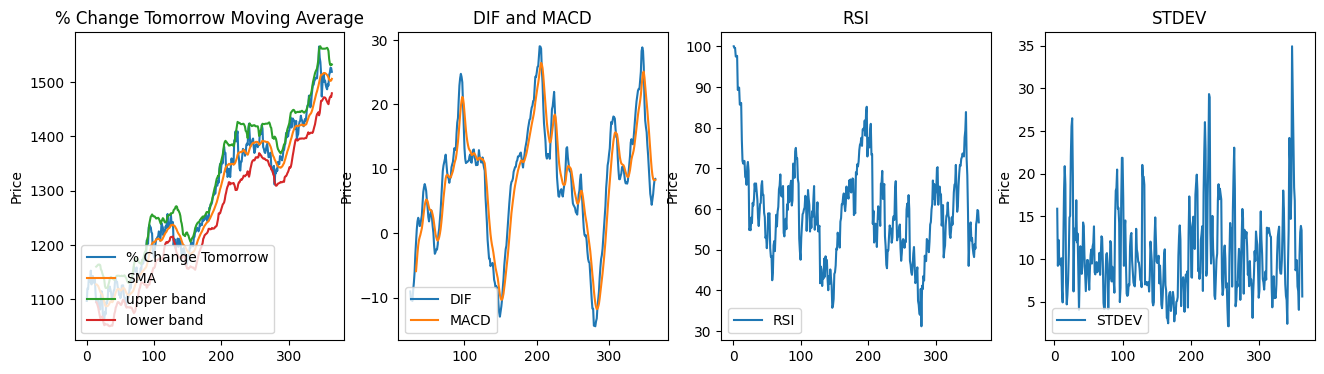

In [67]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))

# Calculate Simple Moving Average
SMA = calculate_SMA(close_price)

close_price[:365].plot(title='% Change Tomorrow Moving Average',label='% Change Tomorrow', ax=axes[0])

SMA[:365].plot(label="SMA",ax=axes[0])


# Calculate Bollinger Bands
upper_band, lower_band = calculate_BB(close_price)

upper_band[:365].plot(label='upper band', ax=axes[0])
lower_band[:365].plot(label='lower band', ax=axes[0])


# Calculate MACD
DIF, MACD = calculate_MACD(close_price)

DIF[:365].plot(title='DIF and MACD',label='DIF', ax=axes[1])
MACD[:365].plot(label='MACD', ax=axes[1])

# Calculate RSI
RSI = calculate_RSI(close_price)
RSI[:365].plot(title='RSI',label='RSI', ax=axes[2])

# Calculating Standard deviation
STDEV= calculate_stdev(close_price)
STDEV[:365].plot(title='STDEV',label='STDEV', ax=axes[3])

Open_Close=dataset.Open - dataset.Price

High_Low=dataset.High-dataset.Low

axes[0].set_ylabel('Price')
axes[1].set_ylabel('Price')
axes[2].set_ylabel('Price')
axes[3].set_ylabel('Price')



axes[0].legend(loc='lower left')
axes[1].legend(loc='lower left')
axes[2].legend(loc='lower left')
axes[3].legend(loc='lower left')

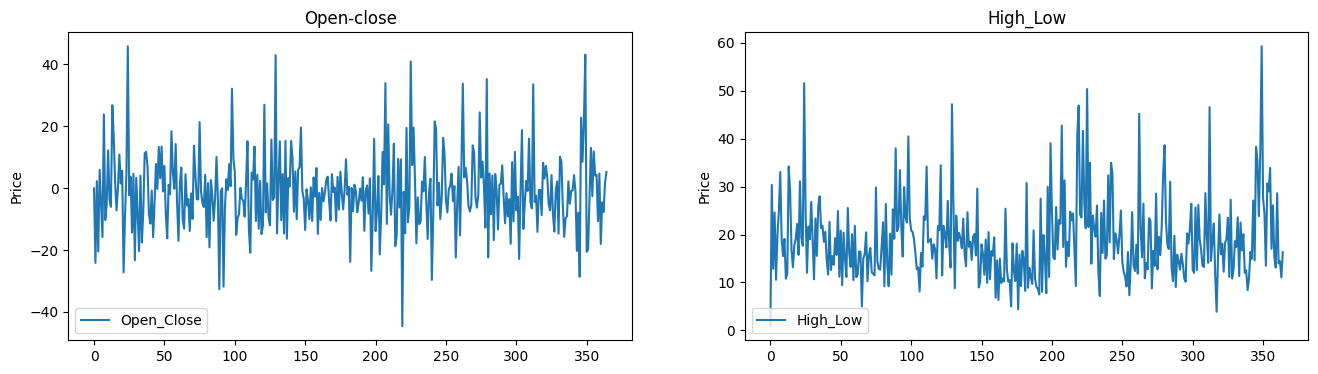

In [68]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
Open_Close=dataset.Open - dataset.Price
Open_Close[:365].plot(title='Open-close',label='Open_Close', ax=axes[0])

High_Low=dataset.High-dataset.Low
High_Low[:365].plot(title='High_Low',label='High_Low', ax=axes[1])
axes[0].set_ylabel('Price')
axes[1].set_ylabel('Price')


axes[0].legend(loc='lower left')
axes[1].legend(loc='lower left')

In [69]:
test = dataset
test['SMA'] = SMA
test['Upper_band'] = upper_band
test['Lower_band'] = lower_band
test['DIF'] = DIF
test['MACD'] = MACD
test['RSI'] = RSI
test['STDEV'] = STDEV
test['Open_Close']=Open_Close
test['High_Low']=High_Low

In [70]:
target_change_tomorrow = pd.DataFrame(test['% Change Tomorrow'])

display(test.head())

,Date,Price,Open,High,Low,% Change,% Change Tomorrow,SMA,Upper_band,Lower_band,DIF,MACD,RSI,STDEV,Open_Close,High_Low
0,1/1/2010,1097.35,1097.25,1097.90,1097.05,0.10,2.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.10,0.85
1,1/4/2010,1120.40,1096.25,1123.80,1093.45,2.10,-0.12,NaN,NaN,NaN,NaN,NaN,100.000000,NaN,-24.15,30.35
2,1/5/2010,1119.05,1121.30,1128.10,1115.25,-0.12,1.77,NaN,NaN,NaN,NaN,NaN,99.583398,NaN,2.25,12.85
3,1/6/2010,1138.90,1118.40,1140.60,1116.00,1.77,-0.58,NaN,NaN,NaN,NaN,NaN,99.609056,NaN,-20.50,24.60
4,1/7/2010,1132.30,1138.20,1139.15,1128.60,-0.58,0.38,NaN,NaN,NaN,NaN,NaN,97.470481,15.888557,5.90,10.55


In [71]:
dataset.columns

Index(['Date', 'Price', 'Open', 'High', 'Low', '% Change', '% Change Tomorrow',
       'SMA', 'Upper_band', 'Lower_band', 'DIF', 'MACD', 'RSI', 'STDEV',
       'Open_Close', 'High_Low'],
      dtype='object')

In [72]:
test_tr = test.copy()
median_SMA = test_tr["SMA"].median()
median_Upper_band = test_tr["Upper_band"].median()
median_Lower_band = test_tr["Lower_band"].median()
median_DIF = test_tr["DIF"].median()
median_MACD = test_tr["MACD"].median()
median_RSI = test_tr["RSI"].median()
median_STDEV = test_tr["STDEV"].median()

test_tr['SMA'].fillna(median_SMA, inplace=True)
test_tr['Upper_band'].fillna(median_Upper_band, inplace=True)
test_tr['Lower_band'].fillna(median_Lower_band, inplace=True)
test_tr['DIF'].fillna(median_DIF, inplace=True)
test_tr['MACD'].fillna(median_MACD, inplace=True)
test_tr['RSI'].fillna(median_RSI, inplace=True)
test_tr['STDEV'].fillna(median_STDEV, inplace=True)

In [73]:
test_tr

,Date,Price,Open,High,Low,% Change,% Change Tomorrow,SMA,Upper_band,Lower_band,DIF,MACD,RSI,STDEV,Open_Close,High_Low
0,1/1/2010,1097.35,1097.25,1097.90,1097.05,0.10,2.10,1380.934667,1423.230471,1328.755813,0.598321,0.497632,51.083614,9.780759,-0.10,0.85
1,1/4/2010,1120.40,1096.25,1123.80,1093.45,2.10,-0.12,1380.934667,1423.230471,1328.755813,0.598321,0.497632,100.000000,9.780759,-24.15,30.35
2,1/5/2010,1119.05,1121.30,1128.10,1115.25,-0.12,1.77,1380.934667,1423.230471,1328.755813,0.598321,0.497632,99.583398,9.780759,2.25,12.85
3,1/6/2010,1138.90,1118.40,1140.60,1116.00,1.77,-0.58,1380.934667,1423.230471,1328.755813,0.598321,0.497632,99.609056,9.780759,-20.50,24.60
4,1/7/2010,1132.30,1138.20,1139.15,1128.60,-0.58,0.38,1380.934667,1423.230471,1328.755813,0.598321,0.497632,97.470481,15.888557,5.90,10.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3640,12/25/2023,2054.93,2054.32,2058.36,2053.96,0.10,0.60,2024.440667,2069.155285,1979.726048,15.289026,13.743245,60.572588,10.431288,-0.61,4.40
3641,12/26/2023,2067.20,2055.73,2068.65,2053.59,0.60,0.47,2027.626000,2077.336155,1977.915845,16.839854,14.362567,62.985107,13.985820,-11.47,15.06
3642,12/27/2023,2077.00,2066.70,2084.59,2061.00,0.47,-0.53,2031.099333,2086.900635,1975.298032,18.644749,15.219003,64.826848,12.502134,-10.30,23.59
3643,12/28/2023,2066.04,2077.34,2088.54,2065.89,-0.53,-0.17,2033.612667,2092.207478,1975.017855,18.972063,15.969615,61.179275,9.828815,11.30,22.65


In [74]:
test_expDate = test_tr.drop("Date", axis=1)
test_fl = test_expDate.drop("% Change Tomorrow", axis=1)

In [75]:
from sklearn.preprocessing import LabelEncoder

# Tạo một đối tượng LabelEncoder
label_encoder = LabelEncoder()

# Fit và chuyển đổi nhãn
encoded_labels = label_encoder.fit_transform(labels)

# In ra danh sách nhãn đã mã hóa
labels_tr = pd.DataFrame({'Label': encoded_labels})


In [76]:
x_train, x_test, y_train, y_test = train_test_split(test_fl, labels_tr, test_size=0.2, random_state=42)
print(x_train.shape)

(2916, 14)
